# Analiza danych

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('zbior_uczacy.txt', sep=';')
df_train.isnull().sum().sum()

0

In [3]:
df = pd.get_dummies(df_train.drop('y', axis=1), drop_first=True)
df['y'] = pd.Categorical(df_train['y'])

Dane składają się ze zmiennych przyjmujących zarówno wartości ciągłe, jak i nominalne, a oprócz tego nie występują żadne brakujące wartości. Zmienne ciągłe mają rozkład jednorodny i przyjmują wartości z przedziału [1, 100]. Zmienne nominalne natomiast rozbite zostały na szereg zmiennych binarnych. Dodatkowo w danych występują dwie klasy "klasa -" oraz "klasa +" o zbliżonej liczności.

# Selekcja zmiennych

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

In [5]:
y = 1 - df['y'].cat.codes.as_matrix()
X = df.drop('y', axis=1).as_matrix()

clf = RandomForestClassifier(random_state=123)
clf = clf.fit(X, y)

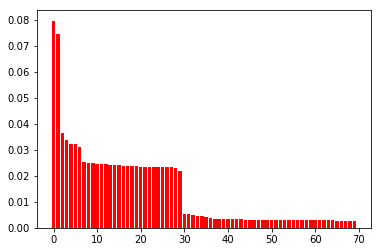

In [6]:
indices = np.argsort(clf.feature_importances_)[::-1]
plt.bar(range(X.shape[1]), clf.feature_importances_[indices], color="r", align="center")
plt.show()

In [7]:
model = SelectFromModel(clf, prefit=True, threshold=0.03)
X_new = model.transform(X)
X_new.shape

(50000, 7)

In [8]:
df.columns[indices][0:7]

Index(['M1', 'W1', 'U2', 'Q1', 'J1', 'T2', 'F2'], dtype='object')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=123)

Selekcja zmiennych dokonana została przy pomocy lasów losowych. Spośród wszystkich zmiennych wybranych zostało 7 najbardziej znaczących. Są to: 'M1', 'W1', 'U2', 'Q1', 'J1', 'T2', 'F2'. Oprócz tego dane podzielone zostały na zbiór treningowy i testowy w proporcji 4:1.

# Funkcja oceny

In [10]:
def compute_score(val, pred, p=0.2):
    n = int(len(pred) * p)
    ind = np.argsort(-pred)
    return np.mean(val[ind][0:n])

Do oceny jakości modelu wykorzystywana jest funkcja określająca dokładność predykcji spośród 20% najwyżej sklasyfikowanych przez model rekordów.

# Regresja logistyczna

In [11]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=0.1, penalty='l1', tol=0.01)
clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_test)[:,1]
score = compute_score(y_test, y_pred)
print(score)

0.668


Dokładność uzyskiwana przez regresję logistyczną wynosi 66,8%.

# Random forest

In [12]:
rf = RandomForestClassifier(random_state=123)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_test)[:,1]
score = compute_score(y_test, y_pred)
print(score)

0.764


Dokładność uzyskiwana przez lasy losowe wynosi 76,4%. Jest to wynik zdecydowanie lepszy niż ten uzyskiwany przez regresję liniową. Możemy więc spodziewać się, że mamy do czynienia z zależnośćią nieliniową.

# XGBoost

In [16]:
import xgboost as xgb

def eval_xgboost(preds, dtrain):
    labels = dtrain.get_label()
    score = compute_score(labels, preds)
    return [('score', score)]

In [14]:
feature_names = df.drop('y', axis=1).columns
dall = xgb.DMatrix(X, label=y, feature_names=feature_names)

param = {'max_depth': 2, 'eta': 0.2, 'objective': 'binary:logistic', 'nthread': 4, 'eval_metric': 'auc'}

res = xgb.cv(param, dall, 101, nfold=5, metrics={'auc'}, seed=123, feval=eval_xgboost,
             callbacks=[xgb.callback.print_evaluation(period=20, show_stdv=False)])

[0]	train-score:0.646325	test-score:0.6512
[20]	train-score:0.7982	test-score:0.7923
[40]	train-score:0.8347	test-score:0.8266
[60]	train-score:0.846975	test-score:0.8363
[80]	train-score:0.850825	test-score:0.8414
[100]	train-score:0.854025	test-score:0.8421


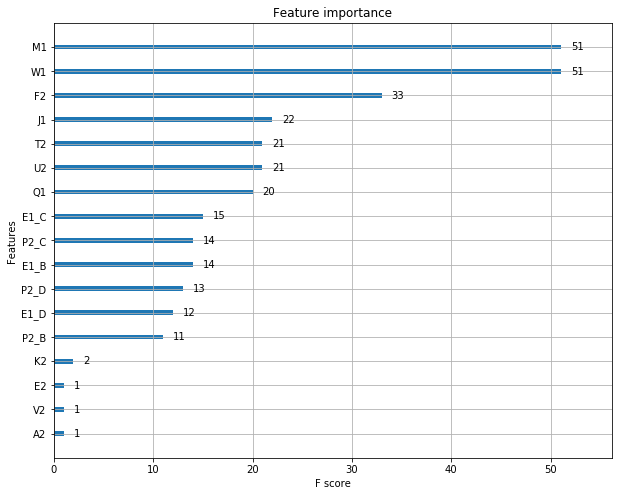

In [15]:
bst = xgb.train(param, dall, 101, verbose_eval=False, feval=eval_xgboost)
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(bst, ax=ax)
plt.show()

Jak widać dokładność uzyskana przez XGBoost wynosi 84,21%, co daje najlepszy wynik spośród wszystkich modeli. Warto zauważyć, że pierwsze siedem zmiennych wysoko cenionych przez model pokrywa się z tymi wyselekcjonowanymi przy pomocy lasów losowych. Jednak W następnej kolejności XGBoost wysoko ceni zmienne nominalne E1 oraz P2.